# The Renin–Angiotensin–Aldosterone System (RAAS)
## RAAS: Function and Biological Purpose
The renin–angiotensin–aldosterone system (RAAS) is a hormonal signaling cascade that regulates blood pressure, fluid volume, and electrolyte balance in the body. It is a key homeostatic mechanism that activates when blood pressure is low to restore it.

### The Classical Model of the RAAS Pathway
![RAAS](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41371-020-00459-3/MediaObjects/41371_2020_459_Fig1_HTML.png?as=webp)
1. **Renin**, an enzyme from the kidney, converts angiotensinogen (from the liver) into **angiotensin I**
2. **Angiotensin-Coverting Enzyme (ACE)** then cleaves angiotensin I into **angiotensin II (Ang II)**
3. **Angiotensin II** is the main effector of the RAAS. This binds to the **angiotensin type 1 receptor** to raise blood pressure by causing the narrowing of blood vessels, stimulating aldosterone release (promoting sodium and water retention), and by activating the sympathetic nervous system.

However, overactivation of the RAAS system could lead to pro-inflammatory and pro-fibrotic (scarring) effects. The excessive activity of Ang II has been implicated in the following:
1. Hypertension
2. Heart Failure
3. Chronic Kidney Disease
4. Cardiovascular remodeling and organ damage

Medications such as ACE inhibitors and ARBs are fundamental for the treatment of these conditions. However, it was also discovered that RAAS isn't a single pathway but a system of "competing" pathways. This was described as a **"pressor" arm** driven by ACE and a **"protective" arm** driven by ACE2.

ACE2 was discovered in 2000 as a homolog of ACE (~60% similarity). The most important reaction catalyzed by ACE2 is the conversion of Ang II into **Ang 1-7**. Ang 1-7 binds to Mas and MrgD receptors, causing vasodilation, smooth muscle relaxation, and lowering pressure in the kidneys.

# ACE2 and COVID-19

In 2003, ACE2 primarily gained more attention beyond its physiology when it was identified as the entry receptor for the SARS coronavirus (SARS-COV). Seventeen years later, a new coronavirus **SARS-COV-2** also uses ACE2 as its gateway into human cells. In fact , the virus has evolved to bind ACE2 with remarkable affinity. This affinity was quantified 10-20 times hgiher than that of the 2003 SARS-CoV spike for ACE2. It should also be noted that the ACE2 receptor is primarily found on the epithelial tissue of the lungs (cite: Human Protein Atlas)

## Mechanism of Viral Entry
Binding is only the first step. The entry of the virus into the host cells also requires the cleavage of the viral Spike protein by host proteases.
1. The viral Spike binds to the ACE2 receptor on the host cell surface.
2. The spike protein is cleaved by the host cell's proteases. The SARS-CoV-2 Spike has a furin cleavage site. This site is cleaved by furin during virus production, which makes the virus more efficient in infecting the host cell.
3. Then after binding to ACE2, the host proteases make a final cut at the S2' site. This activates the Spike's fusion machinery.
4. Finally, the Spike's fusion peptide is unleashed into the host cell membrane, refolding into a more stable state, pulling the viral and cellular membranes together which lets it enter the cytoplasm.

# Working Question
Due to the afforementioned affinity of the SARS-CoV-2 Spike protein for human ACE2, we aim to analyze **which animal species are also suscpetible to infection by SARS-CoV-2.** By analyzing the similarity between the ACE2 orthologs of various vertebrates and the human ACE2 protein, we can infer their potential as hosts for the virus. This python notebook aims to replicate the study made by Liu et. al wherein they tested 48 different ACE2 orthologs and found that 44 of them could succesfully bind the SARS-CoV-2 Spike protein and support viral entry into cells. Furthermore, another study by the same authors also studied the host range for SARS-CoV, a bat CoV and pangolin CoV in the hopes of developing a potential treatment for these viruses.

[1] Fountain JH, Kaur J, Lappin SL. Physiology, Renin Angiotensin System. [Updated 2023 Mar 12]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2025 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK470410/

[2] Bhalla, V., Blish, C.A. & South, A.M. A historical perspective on ACE2 in the COVID-19 era. J Hum Hypertens 35, 935–939 (2021). https://doi.org/10.1038/s41371-020-00459-3

[3] Lan, J., Ge, J., Yu, J. et al. Structure of the SARS-CoV-2 spike receptor-binding domain bound to the ACE2 receptor. Nature 581, 215–220 (2020). https://doi.org/10.1038/s41586-020-2180-5

[4] Li Y, Wang H, Tang X, Fang S, Ma D, Du CWang Y, Pan HYao WZhang R, Zou X, Zheng J, Xu L, Farzan M, Zhong G 2020. SARS-CoV-2 and Three Related Coronaviruses Utilize Multiple ACE2 Orthologs and Are Potently Blocked by an Improved ACE2-Ig. J Virol 94:10.1128/jvi.01283-20.
https://doi.org/10.1128/jvi.01283-20

In [22]:
import os
import math
import numpy as np
import pathlib

from Bio import Entrez
from Bio import SeqIO
from Bio.Align import PairwiseAligner, substitution_matrices
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt


Organisms are retrieved from Functional and genetic analysis of viral receptor ACE2 orthologs reveals a broad potential host range
of SARS-CoV-2 paper. List of accession numbers are shown as follows. Only 11 will be retrieved inclusive of Human ortholog.

| ID | Species | Common Name | NCBI Accession |
|:---|:---|:---|:---|
| #1 | Homo sapiens | Human | NP_001358344.1 |
| #2 | Pan troglodytes | Chimpanzee | XP_016798468.1 |
| | Pan paniscus | Pygmy chimpanzee | XP_008972428.1 |
| #3 | Gorilla gorilla gorilla | Western lowland gorilla | NP_018874749.1 |
| #4 | Nomascus leucogenys | Northern white-cheeked gibbon | XP_003261132.2 |
| #5 | Pongo abelii | Sumatran orangutan | NP_001124604.1 |
| #6 | Macaca mulatta | Rhesus monkey | NP_001129168.1 |
| | Macaca fascicularis | Crab-eating macaque | XP_005593094.1 |
| | Macaca nemestrina | Pig-tailed macaque | XP_011733505.1 |
| | Cercocebus atys | Sooty mangabey | XP_011891198.1 |
| | Mandrillus leucophaeus | Drill | XP_011850923.1 |
| #7 | Papio anubis | Olive baboon | XP_021788732.1 |
| #8 | Theropithecus gelada | Gelada | XP_025227847.1 |
| | Chlorocebus sabaeus | Green monkey | XP_007989304.1 |
| #9 | Rhinopithecus roxellana | Golden snub-nosed monkey | XP_010364367.2 |
| #10 | Piliocolobus tephrosceles | Ugandan red Colobus | XP_023054821.1 |
| #11 | Callithrix jacchus | white-tufted-ear marmoset | XP_008987241.1 |
| #12 | Sapajus apella | Tufted capuchin | XP_032141854.1 |
| | Cebus capucinus imitator | White-headed Capuchin | XP_017367865.1 |
| | Aotus nancymaae | Nancy Ma's Night Monkey | XP_012290105.1 |
| #13 | Saimiri boliviensis boliviensis | Bolivian squirrel monkey | XP_010334925.1 |
| | Propithecus coquereli | (Coquerel's sifaka)monkey | XP_012494185.1 |
| #14 | Oryctolagus cuniculus | Rabbit | XP_002719891.1 |
| | Ochotona princeps | American pika | XP_004597549.2 |
| | Mesocricetus auratus | Golden hamster | XP_005074266.1 |
| #15 | Cricetulus griseus | Chinese hamster | XP_003503283.1 |
| #16 | Peromyscus leucopus | White-footed mouse | XP_028743609.1 |
| | Peromyscus maniculatus bairdii | Prairie Deer Mouse | XP_006973269.1 |
| #18 | Jaculus jaculus | Lesser Egyptian jerboa | XP_004671523.1 |
| #19 | Ictidomys tridecemlineatus | Thirteen-lined ground squirrel | XP_005316051.3 |
| #20 | Sus scrofa | Pig | NP_001116542.1 |
| #21 | Globicephala melas | Long-finned pilot whale | XP_030703991.1 |
| | Lagenorhynchus obliquidens | Pacific white-sided dolphin | XP_026951598.1 |
| #22 | Orcinus orca | Killer whale | XP_004269705.1 |
| #23 | Tursiops truncatus | Common bottlenose dolphin | XP_019781177.1 |
| #24 | Delphinapterus leucas | Beluga whale | XP_022418360.1 |
| | Monodon monoceros | Narwhal | XP_029095804.1 |
| #25 | Neophocaena asiaeorientalis asiaeorientalis | Finless Porpoise | XP_024599894.1 |
| #26 | Lipotes vexillifer | Yangtze River dolphin | XP_007466389.1 |
| #27 | Physeter catodon | Sperm whale | XP_023971279.1 |
| | Balaenoptera acutorostrata scammoni | Minke Whale | XP_028020351.1 |
| #28 | Bos taurus | Cattle | XP_005228485.1 |
| | Bos indicus | Bos taurus indicus | XP_019811719.1 |
| | Bos indicus x Bos taurus | Hybrid cattle | XP_027389727.1 |
| | Bison bison bison | American plain bison | XP_010833001.1 |
| | Odocoileus virginianus texanus | White-tailed fawns | XP_020768965.1 |
| #29 | Bos mutus | Wild yak | XP_005903173.1 |
| #30 | Bubalus bubalis | Water buffalo | XP_006041602.1 |
| #31 | Ovis aries | Sheep | XP_011961657.1 |
| #32 | Capra hircus | Goat | NP_001277036.1 |
| #33 | Rousettus aegyptiacus | Egyptian rousette | XP_015974412.1 |
| | Vombatus ursinus | Common wombat | XP_027691156.1 |
| #34 | Phascolarctos cinereus | Koala | XP_020863153.1 |
| | Trichechus manatus latirostris | Florida manatee | XP_004386381.1 |
| #35 | Equus caballus | Horse | XP_001490241.1 |
| | Equus przewalskii | Przewalski's horse | XP_008542995.1 |
| | Equus asinus | Ass | XP_014713133.1 |
| #36 | Ceratotherium simum simum | Southern white rhinoceros | XP_004435206.1 |
| #37 | Canis lupus familiaris | Dog | NP_001158732.1 |
| | Canis lupus dingo | Dingo dog | XP_025292925.1 |
| #38 | Vulpes vulpes | Red fox | XP_025842512.1 |
| #39 | Ailuropoda melanoleuca | Giant panda | XP_002930657.1 |
| | Ursus maritimus | Polar bear | XP_008694637.1 |
| #40 | Ursus arctos horribilis | Bear | XP_026333865.1 |
| #41 | Zalophus californianus | California sea lion | XP_027465353.1 |
| #42 | Eumetopias jubatus | Steller sea lion | XP_027970822.1 |
| | Callorhinus ursinus | Northern fur seal | XP_025713397.1 |
| | Odobenus rosmarus divergens | Pacific walrus | XP_004415448.1 |
| | Phoca vitulina | Harbor seal | XP_032245506.1 |
| #43 | Neomonachus schauinslandi | Hawaiian monk seal | XP_021536480.1 |
| #44 | Mustela putorius furo | Domestic ferret | NP_001297119.1 |
| | Mustela erminea | Stoat | XP_032187677.1 |
| | Enhydra lutris kenyoni | Sea Otter | XP_022374078.1 |
| #45 | Felis catus | Domestic cat | XP_023104564.1 |
| #46 | Lynx canadensis | Canada lynx | XP_030160839.1 |
| #47 | Acinonyx jubatus | Cheetah | XP_026910297.1 |
| | Puma concolor | Puma | XP_025790417.1 |
| #48 | Panthera pardus | Leopard | XP_019273508.1 |
| | Panthera tigris altaica | Amur tiger | XP_007090142.1 |
| #49 | Manis javanica | Malayan pangolin | XP_017505746.1 |

In [23]:
accession_dict = {
    "Homo sapiens (Human)": "NP_001358344.1",
    "Pan troglodytes (Chimpanzee)": "XP_016798468.1",
    "Callithrix jacchus (Marmoset)": "XP_008987241.1",
    "Felis catus (Cat)": "XP_023104564.1",
    "Canis lupus familiaris (Dog)": "NP_001158732.1",
    "Mustela putorius furo (ferret)": "NP_001297119.1",
    "Rousettus aegyptiacus (Bat)": "XP_015974412.1",
    "Manis javanica (Pangolin)": "XP_017505746.1",
    "Sus scrofa (Pig)": "NP_001116542.1",
    "Peromyscus leucopus(Mouse)": "XP_028743609.1",
    "Bos taurus (Cattle)": "XP_005228485.1",
}

In [24]:
fasta_file = "ace2_orthologs.fasta"
accession_vals = list(accession_dict.values())

try:
    handle = Entrez.efetch(db="protein", id=accession_vals, rettype="fasta", retmode="text", email="abc@efg.com")
    data = handle.read()
    handle.close()
    pathlib.Path(fasta_file).write_text(data)
    print(f"Saved fasta file to {fasta_file}")
except Exception as e:
    print(f"Errror occured: {e}")

Saved fasta file to ace2_orthologs.fasta


In [25]:
fasta_filename = "ace2_orthologs.fasta"
sequences_dict = {}
try:
    with open(fasta_filename, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            common_name = None
            for name, acc in accession_dict.items():
                if acc in record.id:
                    common_name = name
                    break
            if common_name:
                record.id = common_name
                record.description = f"{common_name} ACE2"
                sequences_dict[common_name] = record

    print(">>> Successfully loaded sequences from file. Verification:")
    print("---------------------------------------------------------")
    for name, record in sequences_dict.items():
        print(f"  - {name:<12} ({accession_dict[name]}): {len(record.seq)} amino acids")
    print("---------------------------------------------------------")

except FileNotFoundError:
    print(f"Error: The file '{fasta_filename}' was not found. Please run the download step again.")

>>> Successfully loaded sequences from file. Verification:
---------------------------------------------------------
  - Homo sapiens (Human) (NP_001358344.1): 805 amino acids
  - Pan troglodytes (Chimpanzee) (XP_016798468.1): 805 amino acids
  - Callithrix jacchus (Marmoset) (XP_008987241.1): 805 amino acids
  - Felis catus (Cat) (XP_023104564.1): 807 amino acids
  - Canis lupus familiaris (Dog) (NP_001158732.1): 804 amino acids
  - Mustela putorius furo (ferret) (NP_001297119.1): 805 amino acids
  - Rousettus aegyptiacus (Bat) (XP_015974412.1): 805 amino acids
  - Manis javanica (Pangolin) (XP_017505746.1): 805 amino acids
  - Sus scrofa (Pig) (NP_001116542.1): 805 amino acids
  - Peromyscus leucopus(Mouse) (XP_028743609.1): 805 amino acids
  - Bos taurus (Cattle) (XP_005228485.1): 811 amino acids
---------------------------------------------------------


In [26]:
aligner = PairwiseAligner()
aligner.mode = 'global'
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
aligner.open_gap_score = -5
aligner.extend_gap_score = -3

# BLOSUM Substitution Matrices: What They Are, Why They Matter, and How They Are Built

BLOSUM (for **BLO**cks **SU**bstitution **M**atrix) is a family of log‑odds scoring tables used to judge how evolutionarily “reasonable” an amino‑acid replacement is when two protein sequences are aligned. In practice, alignment algorithms such as BLAST look up the score for every residue pair they compare; conservative substitutions (e.g., leucine to isoleucine) receive positive values, while radical ones (e.g., leucine → aspartate) are penalized. These scores are essential because the raw identity percentage alone cannot capture the underlying biochemistry: some swaps preserve structure or function far better than others.

### From BLOCKS to Log‑Odds

The Henikoffs began with the **BLOCKS** database, which contains multiple‑sequence alignments of short, highly conserved protein motifs. Because these regions are functionally critical, their residue matches are assumed to be biologically correct, giving trustworthy statistics. Within each alignment column, every unique pair of amino acids is counted:

```text
Protein 1: P  I  V  L  Q  K
Protein 2: P  V  V  M  Q  K
Protein 3: A  I  I  L  E  R
Protein 4: P  I  V  L  Q  K
```

For instance, the first column yields the pairings P‑P, P‑A, and A‑P, while the second column produces I‑V, I‑I, and V‑I. Tallying all such pairs gives the **observed frequency** $p_{ij}$ of every possible substitution among related proteins. The **expected frequency** for the same pair, $f_i f_j$, is the product of the individual background probabilities of residues *i* and *j* across the entire data set (alanine, for example, appears \~7.4 % of the time, whereas tryptophan appears only \~1.3 %). The core BLOSUM score is then the base‑2 log‑odds ratio

$$
s_{ij} = \log_2\!\bigl( p_{ij} \,/\, (f_i f_j) \bigr),
$$

followed by multiplication and rounding so the final table contains convenient small integers.

### What is BLOSUM62?

Before counting, sequences that are **$\geq$ 62 % identical** are clustered and treated as a single sequence, ensuring that closely related proteins do not dominate the statistics. A higher BLOSUM number (e.g., BLOSUM80) therefore reflects data from closely related proteins, making it suitable for aligning very similar sequences, while a lower number (e.g., BLOSUM45) derives from distant homologues and is better for remote‑homology searches. **BLOSUM62** offers a middle ground and has become the standard default for most protein‑search tools.

### Construction of BLOSUM

1. **Select trusted motifs** from BLOCKS.
2. **Cluster sequences** sharing ≥ 62 % identity so each family contributes roughly once.
3. **Count every residue pair** in each alignment column to obtain $p_{ij}$.
4. **Calculate background frequencies** $f_i$ for all 20 amino acids.
5. **Compute log‑odds**, scale, and round to generate an integer matrix.

### Using BLOSUM in Alignment

In this notebook, the residue scores are derived from BLOSUM62, while separate affine gap penalties are added for insertions and deletions. The summed score along the optimal path distinguishes real evolutionary relationships from chance similarity; positive totals suggest homology.

[1] Henikoff S., Henikoff J.G. (1992) *Amino‑acid substitution matrices from protein blocks.* **PNAS** 89 (22): 10915‑10919.
[2] Altschul S.F. (2002) *Empirical determination of effective gap penalties for sequence comparison.* **Bioinformatics** 18 (11): 1500‑1507.
[3] NCBI BLAST workshop notes, “Why BLOSUM62 is the default.”


In [27]:
def get_best_alignment(aligner, seq1, seq2): return aligner.align(seq1, seq2)[0]

def compute_percent_identity(aligned1, aligned2): return sum(a == b for a, b in zip(aligned1, aligned2)) / len(aligned1) * 100

def extract_key_residues(aligned_human, aligned_other, key_positions):
    ungapped_to_aln = [i for i, c in enumerate(aligned_human) if c != '-']
    residues = {}
    for pos in key_positions:
        if pos - 1 < len(ungapped_to_aln):
            aln_idx = ungapped_to_aln[pos - 1]
            residues[pos] = aligned_other[aln_idx]
        else:
            residues[pos] = '-'
    return residues

def analyze_against_human(sequences, aligner, human_key, key_positions):
    human_seq = sequences[human_key].seq
    identity_scores = {}
    key_residues = {}

    for name, record in sequences.items():
        if name == human_key: continue
        aln = get_best_alignment(aligner, human_seq, record.seq)
        h_aln, o_aln = aln[0], aln[1]
        pct_id = compute_percent_identity(h_aln, o_aln)
        identity_scores[name] = (aln.score, pct_id)
        key_residues[name] = extract_key_residues(h_aln, o_aln, key_positions)

    return identity_scores, key_residues

KEY_POSITIONS = [31, 35, 38, 41, 42, 82, 353]
HUMAN_NAME = "Homo sapiens (Human)"
identity_scores, key_residues = analyze_against_human(sequences_dict, aligner, HUMAN_NAME, KEY_POSITIONS)
print("All pairwise alignments complete")


All pairwise alignments complete


In [28]:
# table 1: alignment scores and identity
print("-" * 60)
print(f"{'Species':<30} | {'Score':>7} | {'Identity (%)':>12}")
print("-" * 60)

for name, (score, identity) in identity_scores.items():
    print(f"{name:<30} | {score:7.1f} | {identity:11.2f}%")

print(f"{'Human':<30} | {'-':>7} | {'-':>12}")
print("-" * 60)


------------------------------------------------------------
Species                        |   Score | Identity (%)
------------------------------------------------------------
Pan troglodytes (Chimpanzee)   |  4253.0 |       99.01%
Callithrix jacchus (Marmoset)  |  3957.0 |       91.68%
Felis catus (Cat)              |  3697.0 |       84.63%
Canis lupus familiaris (Dog)   |  3639.0 |       83.48%
Mustela putorius furo (ferret) |  3629.0 |       82.63%
Rousettus aegyptiacus (Bat)    |  3482.0 |       78.88%
Manis javanica (Pangolin)      |  3679.0 |       84.84%
Sus scrofa (Pig)               |  3567.0 |       81.37%
Peromyscus leucopus(Mouse)     |  3633.0 |       83.11%
Bos taurus (Cattle)            |  3441.0 |       78.38%
Human                          |       - |            -
------------------------------------------------------------


Our finding reveals that the orthologs from the selected species contain the relevant amino acids at positions 31, 35, 38, 82 and 353. These positions are critical for SARS-CoV-2 spike binding. Multiple analyses into these residues have labelled them as hotspots which determines a host's susceptibility to the virus. For example, the study by Liu et. al revealed that mammals with Lys31, Glu35, Asp38, Met82, and Lys353 (matching the human ACE2) were far more likely to serve as effective SARS-CoV-2 receptors. ACE2 from animals like cats, ferrets, hamsters, primates, cattle, and others could bind the spike protein and permit entry of the virus. In contrast, species with substitions at these critical sites tend to be poor hosts. Notably, New World Monkeys were found to be resistant to SARS-CoV-2 infection. 

### Significance of ACE2 Positions
1. **K31**: In human ACE2, K31 forms a salt bridge with Glu35 on the same protein, creating a stable motif. Furthermore, K31 also forms an equivalent hydrogen-bond with Gln493 on the SARS-CoV-2 spike. The **K31–E35** pairing in ACE2 is therefore essential in permitting the entry of the virus, which makes it ripe for the exploitation by SARS-CoV-2. Mutations within these regions drops virus-binding affinity significantly.
2. **K353**: This residue located in a loop of ACE2 is also an anchor point. This site forms a a salt bridge with Asp38 in ACE2 and together this stabilizes the binding interface. This position also directly interacts with the virus's receptor-binding domain.
3. **M82**: This residue lies in a pocket on ACE2 that interfaces with the viral spike. M82 provides a hydrophobic contact with the spike’s **F486**.

[1] Liu, Y., Hu, G., Wang, Y., Ren, W., Zhao, X., Ji, F., Zhu, Y., Feng, F., Gong, M., Ju, X., Zhu, Y., Cai, X., Lan, J., Guo, J., Xie, M., Dong, L., Zhu, Z., Na, J., Wu, J., Lan, X., … Ding, Q. (2021). Functional and genetic analysis of viral receptor ACE2 orthologs reveals a broad potential host range of SARS-CoV-2. Proceedings of the National Academy of Sciences of the United States of America, 118(12), e2025373118. https://doi.org/10.1073/pnas.2025373118

In [29]:
human_record = sequences_dict[HUMAN_NAME]

print("\nKey Residues:")
print("-" *100)
print(f"{'Species':<30} | {'Pos 31':>7} | {'Pos 35':>7} | {'Pos 38':>7} | {'Pos 41':>7} | {'Pos 42':>7} | {'Pos 82':>7} | {'Pos 353':>7}")
print("-" * 100)

for name, residues in key_residues.items():
    print(f"{name:<30}"
          + "".join(f" | {residues.get(pos, '-'):>7}" for pos in [31, 35, 38, 41, 42, 82, 353]))

print(f"{'Human':<30}"
      + f" | {human_record.seq[30]:>7} | {human_record.seq[34]:>7} | {human_record.seq[38]:>7} | {human_record.seq[40]:>7}"
      + f" | {human_record.seq[41]:>7} | {human_record.seq[81]:>7} | {human_record.seq[352]:>7}")
print("-" * 100)

print("\nDiscussion Point: For example, Y41 and Q42 in human ACE2 are responsible for the formation of hydrogen bonds with S protein and are highly conserved "
      "\nacross all other species [to paraphrase].")
print("\nNote the residues for Marmoset (H, E) at positions 41 and 42, which differ from the Human (Y, Q), as highlighted in the PNAS paper.")


Key Residues:
----------------------------------------------------------------------------------------------------
Species                        |  Pos 31 |  Pos 35 |  Pos 38 |  Pos 41 |  Pos 42 |  Pos 82 | Pos 353
----------------------------------------------------------------------------------------------------
Pan troglodytes (Chimpanzee)   |       K |       E |       D |       Y |       Q |       M |       K
Callithrix jacchus (Marmoset)  |       K |       E |       D |       H |       E |       T |       K
Felis catus (Cat)              |       K |       E |       E |       Y |       Q |       T |       K
Canis lupus familiaris (Dog)   |       K |       E |       E |       Y |       Q |       T |       K
Mustela putorius furo (ferret) |       K |       E |       E |       Y |       Q |       T |       K
Rousettus aegyptiacus (Bat)    |       K |       E |       D |       Y |       Q |       T |       K
Manis javanica (Pangolin)      |       K |       E |       E |       Y |    

## p-distance

As in the case for nucleotide sequences, the p-distance is merely the proportion of different amino acids between two sequences compared. Therefore, the statistical properties of this distance are the same as those of the p-distance for nucleotide sequence data.

$$
p = n_d/n
$$

$$
V(p) = p(1 - p)/n
$$

Here n$_d$ and n are the number of amino acid differences and the total number of amino acids compared, respectively.

In [32]:
def compute_p_distance(seq1, seq2):
    mismatches = 0
    aligned_len_no_gaps = 0
    for i in range(len(seq1)):
        if seq1[i] != '-' and seq2[i] != '-':
            aligned_len_no_gaps += 1
            if seq1[i] != seq2[i]:
                mismatches += 1
    
    if aligned_len_no_gaps == 0:
        return 0.0

    # p-distance is the proportion of non-identical sites
    p_dist = mismatches / aligned_len_no_gaps
    return p_dist

In [33]:
HUMAN_NAME = "Homo sapiens (Human)"

alignments_dict = {}
human_seq = sequences_dict[HUMAN_NAME].seq

for name, record in sequences_dict.items():
    if name == HUMAN_NAME:
        continue
    alignment = aligner.align(human_seq, record.seq)[0]
    alignments_dict[name] = alignment  

In [34]:
species_names = list(sequences_dict.keys())
num_species = len(species_names)

print("\nP-distance to Human:")
print("-" * 30)
print(f"{'Species':<30} | {'p-distance':>10}")
print("-" * 30)

for species in species_names:
    if species == "Homo sapiens (Human)":
        continue
    # aligned sequences from the alignment Human vs species
    aligned_human = alignments_dict[species][0]
    aligned_other = alignments_dict[species][1]

    p_dist = compute_p_distance(aligned_human, aligned_other)
    print(f"{species:<30} | {p_dist:10.4f}")




P-distance to Human:
------------------------------
Species                        | p-distance
------------------------------
Pan troglodytes (Chimpanzee)   |     0.0099
Callithrix jacchus (Marmoset)  |     0.0832
Felis catus (Cat)              |     0.1516
Canis lupus familiaris (Dog)   |     0.1642
Mustela putorius furo (ferret) |     0.1716
Rousettus aegyptiacus (Bat)    |     0.2112
Manis javanica (Pangolin)      |     0.1516
Sus scrofa (Pig)               |     0.1863
Peromyscus leucopus(Mouse)     |     0.1689
Bos taurus (Cattle)            |     0.2045


### Poisson-correction distance

This distance is for estimating the number of amino acid substitutions per site under the assumption that the number of amino acid substitutions at each site follows the Poisson distribution. This estimator (a) and its variance are given by

$$d = -\log_e(1-p) \quad (4.50)$$

$$V(d) = \frac{p}{(1-p)n} \quad (4.51)$$

The basic p-distance is simply the proportion of amino acids that differ between two sequences. This assumes that each difference is a single mutation and that sites haven't mutated more than once. However, as sequences diverge more, this assumption breaks down. Which means as evolution happens, some positions might mutate multiple times, which the p-distance cannot detect. This means the p-distance tends to **underestimate** the true evolutionary distance when divergence is high.

The **poisson correction** corrects this by assuming that the mutations follow a Poisson process. It provides a better **"guesstimate"**, taking into account how many times a mutation has happened over the sequence's lifetime. The poisson-corrected distance is given by $d=-ln(1-p)$m where p is the observed fraction of differences. This formula comes from the Poisson probability of zero changes at a site: if $p$ of sites are changed, then $1–p$ is the fraction unchanged, and $–ln(1–p)$ estimates the average number of substitutions per site. The corrected distance d will always be $\geq p$, and grows larger than $p$ as $p$ increases. 

[1] Nei, M. and Zhang, J. (2006). Evolutionary Distance: Estimation. In eLS, John Wiley & Sons, Ltd (Ed.). https://doi.org/10.1038/npg.els.0005108

In [35]:
def compute_poisson_distance(seq1, seq2):
    p_dist = compute_p_distance(seq1, seq2)
    if p_dist >= 1.0:
        return float('inf')  # Avoid log(0) or negative values
    return -math.log(1 - p_dist)


In [36]:
species_names = list(sequences_dict.keys())
num_species = len(species_names)

print("\nPoisson corrected distance to Human:")
print("-" * 30)
print(f"{'Species':<30} | {'poisson-distance':>10}")
print("-" * 30)

for species in species_names:
    if species == "Homo sapiens (Human)":
        continue
    aligned_human = alignments_dict[species][0]
    aligned_other = alignments_dict[species][1]

    p_dist = compute_poisson_distance(aligned_human, aligned_other)
    print(f"{species:<30} | {p_dist:10.4f}")




Poisson corrected distance to Human:
------------------------------
Species                        | poisson-distance
------------------------------
Pan troglodytes (Chimpanzee)   |     0.0100
Callithrix jacchus (Marmoset)  |     0.0869
Felis catus (Cat)              |     0.1643
Canis lupus familiaris (Dog)   |     0.1793
Mustela putorius furo (ferret) |     0.1883
Rousettus aegyptiacus (Bat)    |     0.2372
Manis javanica (Pangolin)      |     0.1643
Sus scrofa (Pig)               |     0.2062
Peromyscus leucopus(Mouse)     |     0.1851
Bos taurus (Cattle)            |     0.2288


to do a dendogram, you need pairwise sequence alignment of all-all, not just one species-human

In [37]:
distances = np.zeros((num_species, num_species))  # initialize full matrix

for i in range(num_species):
    for j in range(i):  # only compute for lower triangle
        species1 = species_names[i]
        species2 = species_names[j]

        record1 = sequences_dict[species1]
        record2 = sequences_dict[species2]

        alignment = aligner.align(record1.seq, record2.seq)[0]
        corrected_distance = compute_poisson_distance(alignment[0], alignment[1])

        distances[i][j] = corrected_distance
        distances[j][i] = corrected_distance  # mirror

A->B, B->A

In [38]:
distances

array([[0.        , 0.0099876 , 0.08689845, 0.16434742, 0.17934093,
        0.1883096 , 0.23721728, 0.16434742, 0.20620704, 0.18505822,
        0.22877032],
       [0.0099876 , 0.        , 0.08825439, 0.16288436, 0.17934093,
        0.18381521, 0.23564371, 0.16288436, 0.20620704, 0.18955261,
        0.23033895],
       [0.08689845, 0.08825439, 0.        , 0.1865541 , 0.20649192,
        0.20649192, 0.24989574, 0.1865541 , 0.21849598, 0.18805223,
        0.24616207],
       [0.16434742, 0.16288436, 0.1865541 , 0.        , 0.10204925,
        0.11298092, 0.21540956, 0.13566587, 0.17909695, 0.20039434,
        0.21167589],
       [0.17934093, 0.17934093, 0.20649192, 0.10204925, 0.        ,
        0.10896013, 0.22034895, 0.14013561, 0.19735943, 0.20677758,
        0.21351465],
       [0.1883096 , 0.18381521, 0.20649192, 0.11298092, 0.10896013,
        0.        , 0.20677758, 0.14405687, 0.17612959, 0.20191525,
        0.22595649],
       [0.23721728, 0.23564371, 0.24989574, 0.21540956, 0.

TO DO: NOT SURE IF THIS IS CORRECT
Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

WIKIPEDIA REFERENCE PROVIDED BY DOC:
https://en.wikipedia.org/wiki/UPGMA

In [39]:
condensed = squareform(distances)

In [40]:
condensed

array([0.0099876 , 0.08689845, 0.16434742, 0.17934093, 0.1883096 ,
       0.23721728, 0.16434742, 0.20620704, 0.18505822, 0.22877032,
       0.08825439, 0.16288436, 0.17934093, 0.18381521, 0.23564371,
       0.16288436, 0.20620704, 0.18955261, 0.23033895, 0.1865541 ,
       0.20649192, 0.20649192, 0.24989574, 0.1865541 , 0.21849598,
       0.18805223, 0.24616207, 0.10204925, 0.11298092, 0.21540956,
       0.13566587, 0.17909695, 0.20039434, 0.21167589, 0.10896013,
       0.22034895, 0.14013561, 0.19735943, 0.20677758, 0.21351465,
       0.20677758, 0.14405687, 0.17612959, 0.20191525, 0.22595649,
       0.20620704, 0.22159196, 0.26597325, 0.27201165, 0.19105524,
       0.18805223, 0.21971622, 0.21386991, 0.16207895, 0.23505965])

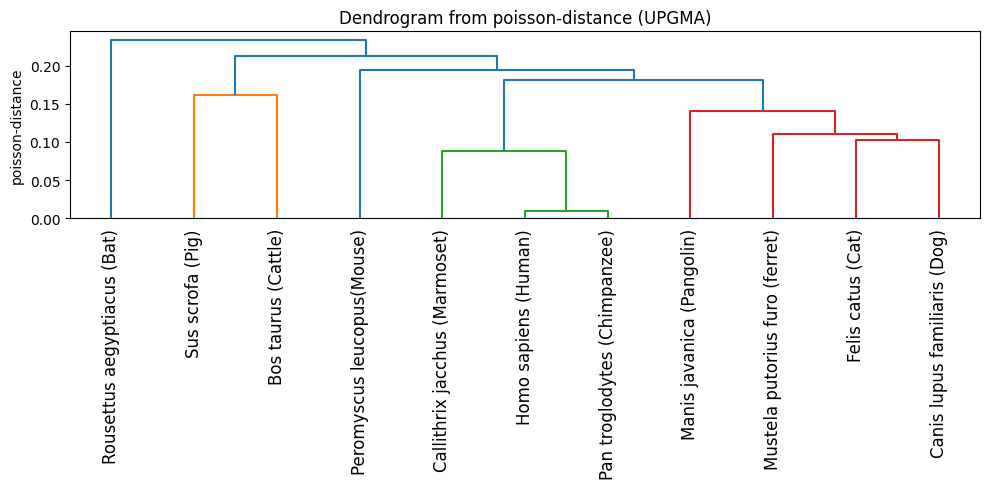

In [41]:
linkage_matrix = linkage(condensed, method='average')  # UPGMA

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=species_names, leaf_rotation=90)
plt.title("Dendrogram from poisson-distance (UPGMA)")
plt.ylabel("poisson-distance")
plt.tight_layout()
plt.show()
